## In case this program fails to run on Google Colab due to low RAM, Please try to run it on your local machine.

In [1]:
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler


## Loading the dataset into a single DataFrame

In [3]:
# Load the data into a pd DataFrame
listOfCsv = [
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/fuelDensity.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/fuelTemp.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/fuelVolumeFlowRate.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/inclinometer-raw.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/latitude.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/portPitch.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/portRudder.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/speedKmh.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/speedKnots.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/longitude.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/level1median.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/level2median.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/longitudinalWaterSpeed.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/trackDegreeTrue.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/trueHeading.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/windAngle.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/windSpeed.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/starboardPitch.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/starboardRudder.csv",
  "https://randomfilesbucket01903933.s3.eu-north-1.amazonaws.com/csv-files/trackDegreeMagnetic.csv",
]

data_df = None

temp_df = {}
for url in listOfCsv:
  featureName = (url.split('/')[-1].split('.')[0].split('-'))[0]
  temp_df[featureName] = pd.read_csv(url, names=["timeStamp", featureName])

for _, df in temp_df.items():
    if data_df is None:
        data_df = df
    else:
        # Merge on the common column
        data_df = pd.merge(data_df, df, on='timeStamp', how='outer')



## Feature Engineering

In [4]:
# Function to convert from .NET tick to timeStamp
def convertToTimeStamp(ticks: float):
    unix_timestamp = (ticks - 621355968000000000) * 100
    human_readable = pd.to_datetime(unix_timestamp,  unit='ns', errors='coerce')
    return human_readable

data_df['timeStamp'] = convertToTimeStamp(data_df['timeStamp'])


In [5]:
# Set the timeStamp as the index of the DataFrame.
data_df.set_index('timeStamp', inplace=True)


# Drop the longitude and latitude columns as I believe it has no effect on what we're trying to achieve
filtered_df = data_df.drop(['longitude', 'latitude'], axis=1)

In [6]:
# Resample the dataframe and aggregrating the data to every 5 mins by the mean/average
resampled_data = filtered_df.resample('5min').mean()

# Dropping all empty/null data
processed_df =  resampled_data.dropna()

processed_df.head()

,fuelDensity,fuelTemp,fuelVolumeFlowRate,inclinometer,portPitch,portRudder,speedKmh,speedKnots,level1median,level2median,longitudinalWaterSpeed,trackDegreeTrue,trueHeading,windAngle,windSpeed,starboardPitch,starboardRudder,trackDegreeMagnetic
timeStamp,,,,,,,,,,,,,,,,,,
2010-02-16 12:45:00,0.932952,91.291593,0.401860,357.626545,2.580472,-1.743849,6.565455,3.542727,16.831812,14.250778,2.523529,205.336697,182.776067,246.925926,15.603704,3.932858,0.709689,212.536697
2010-02-16 12:50:00,0.932997,91.396970,0.468022,357.346926,5.971677,0.269107,27.256169,14.717208,17.257378,14.068839,14.168421,147.907792,153.962800,288.560000,20.835333,7.264843,0.242117,155.107792
2010-02-16 12:55:00,0.929404,94.965989,0.497874,357.244191,6.643037,-0.305057,36.044118,19.462092,17.264218,14.331844,17.144792,148.231699,163.029080,295.426667,21.796667,8.002727,-0.318983,155.431699
2010-02-16 13:00:00,0.927618,96.527056,0.498492,357.232913,6.656204,-0.234381,36.037662,19.456169,16.983671,14.309368,17.236842,177.993506,185.754960,278.206667,11.824667,7.978696,-0.252043,185.193506
2010-02-16 13:05:00,0.927148,96.869316,0.501298,357.247945,6.702610,-0.269063,37.381107,20.187948,16.919800,14.585371,17.344211,229.801303,236.429240,177.733333,7.718667,8.062333,-0.300360,237.001303


In [8]:
# Calculate the energy consumption for every 5 minutes and add the column to the DataFrame.
processed_df.loc[:, 'EC'] =  (processed_df['fuelDensity'] * processed_df['fuelVolumeFlowRate'] * 300) /1000

<Axes: >

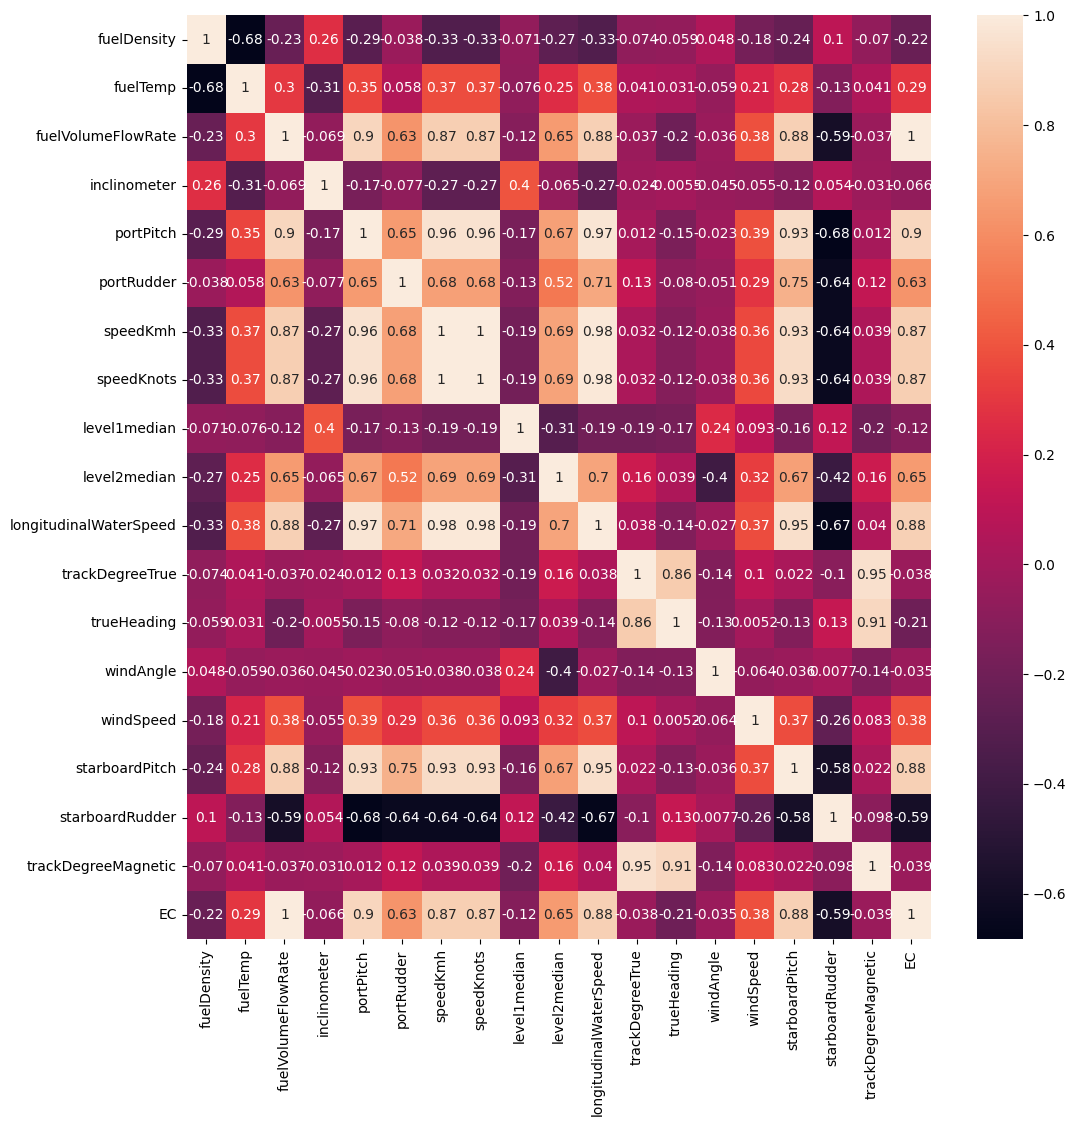

In [9]:
# Plot a chart to examine the correlation between all features and the EC
plt.figure(figsize=(12,12))
sns.heatmap(processed_df.corr(numeric_only=True), annot=True)

<Axes: >

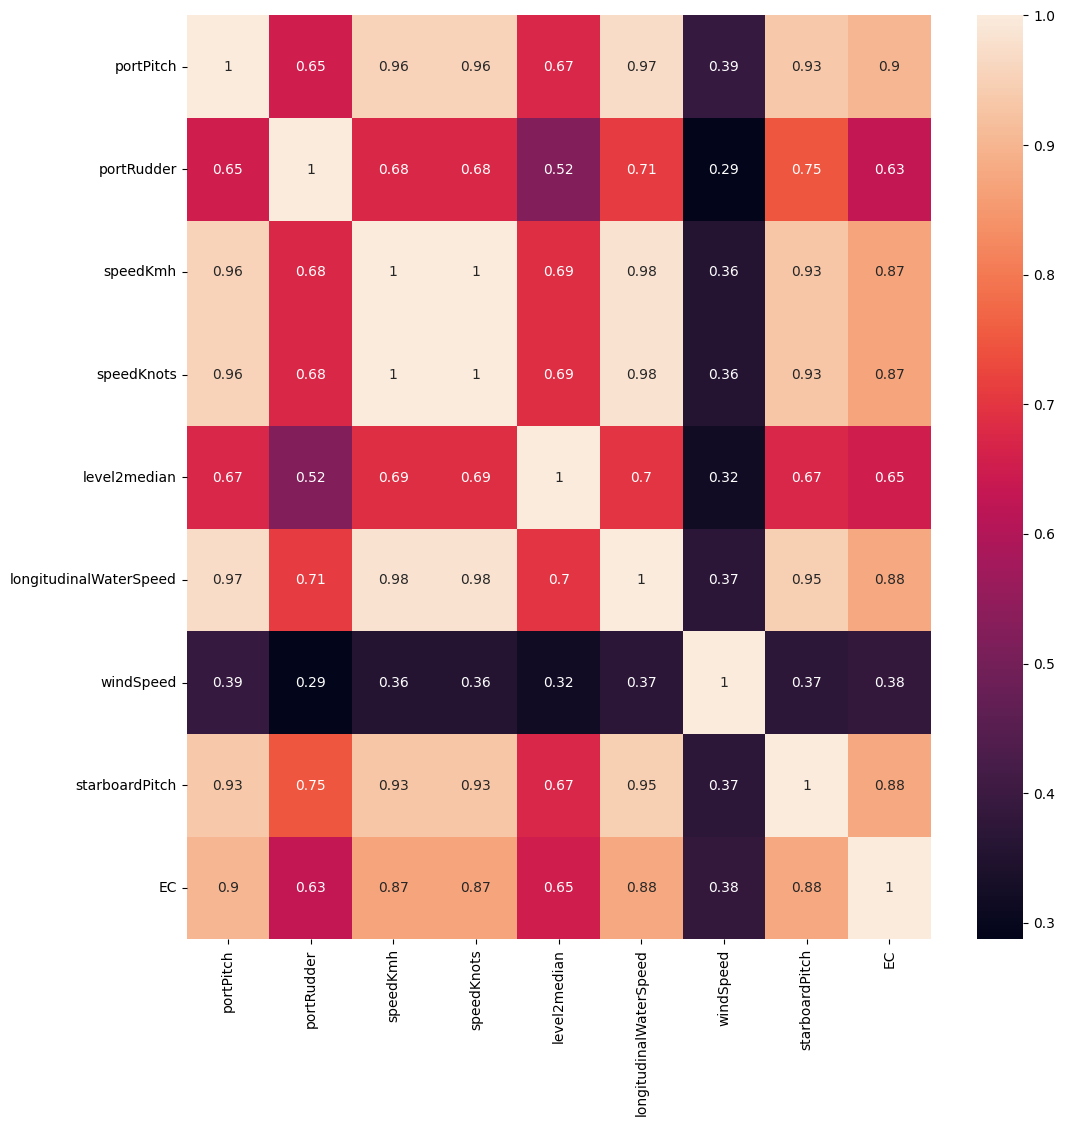

In [10]:
# After examining the correlation map and using an window interval of 0.35 - 0.95, the following features will be used to train the learning algorithms:
# portRudder, speedKmh, speedKnots, speedKnots level2median, longitudinalWaterSpeed, windSpeed, starboardPitch
selected_features = ['portPitch', 'portRudder', 'speedKmh', 'speedKnots', 'level2median', 'longitudinalWaterSpeed', 'windSpeed', 'starboardPitch']

# Let's run a correlation between the selected features and the grade
plt.figure(figsize=(12,12))
sns.heatmap(processed_df[selected_features + ['EC']].corr(numeric_only=True), annot=True)

# Exploratory Data Analysis

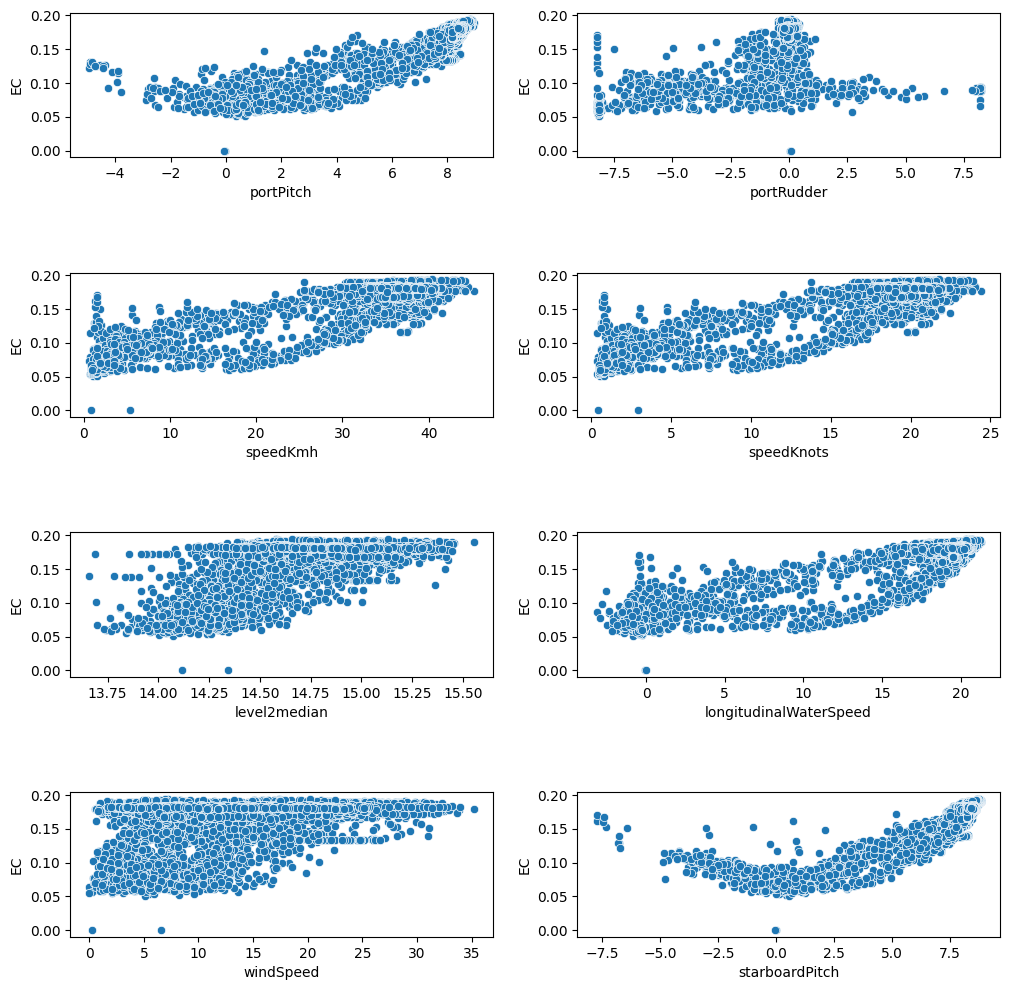

In [11]:
# Display a scatter plot to show the relationship between each selected feature and the energy consumption.
plt.figure(figsize=(12, 12))
for i, feature in enumerate(selected_features):
    plt.subplot(4, 2, i + 1)
    plt.subplots_adjust(hspace=0.8)
    sns.scatterplot(data=processed_df, x=feature, y='EC')


In [13]:
X = processed_df[selected_features]
y = processed_df['EC']

# Define models
models = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
}

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results[name] = {"R² Score": r2 * 100, "RMSE": rmse, "MAE": mae}

results_df = pd.DataFrame(results)

results_df.transpose().head()



,R² Score,RMSE,MAE
Decision Tree,97.443558,0.005210,0.002880
Random Forest,98.419411,0.004097,0.002360
Gradient Boosting,98.511714,0.003975,0.002282


**Summary of Model Comparison**  
The Decision Tree, Random Forest, and Gradient Boosting models exhibit differences in performance due to their inherent algorithmic designs. The **Decision Tree** typically shows the lowest accuracy and higher variance, as it relies on a single tree prone to overfitting noisy or complex data. In contrast, **Random Forest**, an ensemble of decorrelated trees using bagging and feature randomness, reduces overfitting and improves generalization by averaging predictions, leading to higher accuracy. **Gradient Boosting** outperforms both by iteratively building trees that correct prior errors (boosting), optimizing loss functions directly. Its sequential learning approach captures complex patterns more effectively, especially in datasets with non-linear relationships, but it is computationally heavier and risks overfitting if not regularized properly.

**Reasons for Performance Differences**  
The gap arises from how each model handles bias-variance trade-offs and data complexity. Decision Trees struggle with high variance, while Random Forest’s bagging reduces variance at the cost of interpretability. Gradient Boosting minimizes bias through error correction, excelling in accuracy but requiring careful tuning. Differences in feature interactions, hyperparameters (e.g., tree depth, learning rate), and data scaling also contribute. For energy consumption prediction, Gradient Boosting’s sensitivity to nuanced patterns in ship sensor data (e.g., pitch, speed interactions) likely gives it an edge, whereas Random Forest offers robustness with less tuning effort. The choice depends on balancing accuracy needs, computational resources, and interpretability.